In [1]:
import os
import sys
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = 'datasets/dataset1/train'  # Path to your dataset

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = datasets.ImageFolder(data_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [3]:
model = models.vgg19(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False

num_classes = 7  # Number of classes
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, num_classes)

C:\Users\enesk\anaconda3\envs\facial-expression\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\enesk\anaconda3\envs\facial-expression\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

import matplotlib.pyplot as plt

# Initialize lists to store per-epoch loss
train_losses = []
val_losses = []

num_epochs = 50  # Or any other number of epochs you're using
patience = 5
best_val_loss = np.Inf
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Calculate average losses
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')
    
    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

Epoch 1, Train Loss: 1.6847965635961144, Validation Loss: 1.5596000578668383
Epoch 2, Train Loss: 1.5065070131695038, Validation Loss: 1.3691041886806488
Epoch 3, Train Loss: 1.4021933040579049, Validation Loss: 1.3202101012070975
Epoch 4, Train Loss: 1.3259059194900864, Validation Loss: 1.3078633334901597
Epoch 5, Train Loss: 1.2658429052836384, Validation Loss: 1.28155956864357
Epoch 6, Train Loss: 1.206995979242006, Validation Loss: 1.257764666610294
Epoch 7, Train Loss: 1.1469861633432277, Validation Loss: 1.2620003034671148
Epoch 8, Train Loss: 1.0956540854030332, Validation Loss: 1.2351868473821217
Epoch 9, Train Loss: 1.0571824684531577, Validation Loss: 1.2515653524133894
Epoch 10, Train Loss: 1.009285958032422, Validation Loss: 1.265310303039021
Epoch 11, Train Loss: 0.9649505279024332, Validation Loss: 1.2675303743945228
Epoch 12, Train Loss: 0.9374509763833873, Validation Loss: 1.2978599846363068
Epoch 13, Train Loss: 0.8839369793124185, Validation Loss: 1.282440158393648
Ea

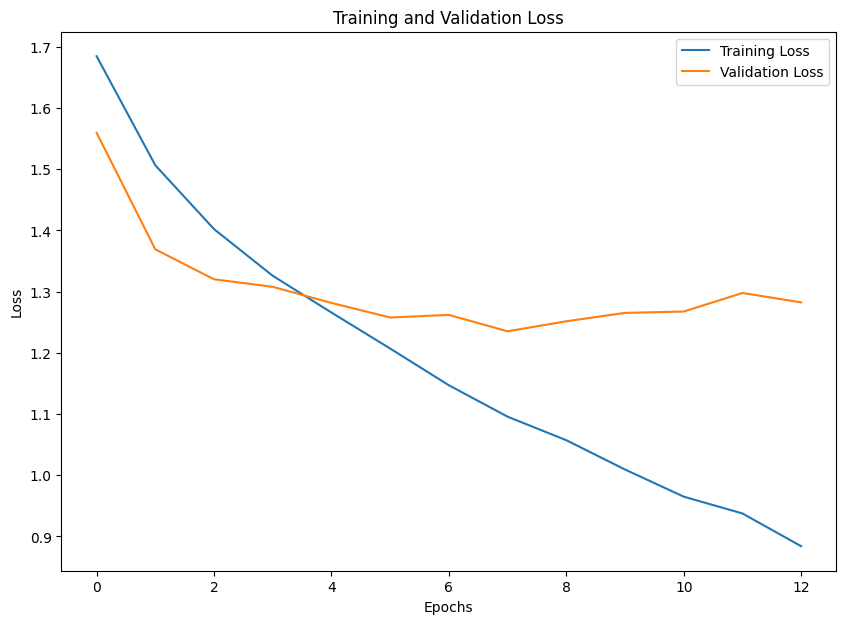

In [6]:
import matplotlib.pyplot as plt
# Load the best model weights
model.load_state_dict(best_model_wts)

# Plotting training and validation loss
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [8]:
model_path = 'cnn_vgg.pth'
torch.save(model.state_dict(), model_path)